# Spooky Author EDA

Let's start by importing the standard modules

In [3]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # better styling

import matplotlib
matplotlib.rcParams.update({'font.size': 26})

# Get a list of standard stopwords
# If this gives an error, run the cell below and rerun this one
# bash /Applications/Python 3.6/Install Certificates.command
nltk.download('stopwords')
nltk.download('punkt')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/damien/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/damien/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Use this if you get a certificate error
#!bash /Applications/Python\ 3.6/Install\ Certificates.command

## General EDA (Model agnostic)

In [5]:
all_docs = pd.read_csv('./data/train.csv')
all_docs.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [6]:
mask = np.random.random(size=len(all_docs)) < 0.8
train= all_docs[mask]
test = all_docs[~mask]

In [7]:
# What percentage of documents belong to each author?
train.author.value_counts(normalize=True)

EAP    0.405928
MWS    0.306456
HPL    0.287616
Name: author, dtype: float64

i.e. we can get 40% accuracy by guessing Edgar Allen Poe (EAP) wrote all the books!

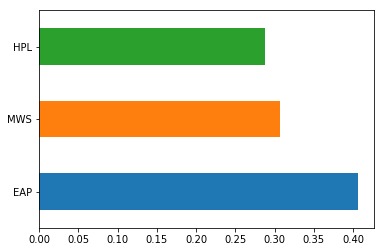

In [8]:
# see same info graphically:
train.author.value_counts(normalize=True).plot('barh');

In [9]:
print("Columns are " +  str(list(train.columns)))
print("Number of rows of data are " + str(train.shape[0]))

Columns are ['id', 'text', 'author']
Number of rows of data are 15552


### Word frequency model

For each author:
1. Find the body of text they wrote
2. Remove the "stop words"
3. Find the (normalized) frequency of each word

In [10]:
import string
stopwords = nltk.corpus.stopwords.words('english')

def clean_text(text):
    text = text.encode('ascii', 'ignore').decode('utf-8')
    return [word for word in nltk.word_tokenize(text.lower()) if word[0] in string.ascii_letters and word not in stopwords]


In [11]:
print("Original text:" + train.text[0])
print("Cleaned text:" + str(clean_text(train.text[0])))

Original text:This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
Cleaned text:['process', 'however', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', 'might', 'make', 'circuit', 'return', 'point', 'whence', 'set', 'without', 'aware', 'fact', 'perfectly', 'uniform', 'seemed', 'wall']


In [12]:
# nltk FreqDist gets the frequency distribution of a list
# Functionally similar to
def mock_freq_dist(iterable):
    freq_table = {}
    for item in iterable:
        freq_table[item] = freq_table.get(item, 0) + 1
    return freq_table

# Differences are that FreqDist has some nice helper functions (such as "most common")
#nltk.FreqDist(clean_text(train.text[0]))

In [13]:
def process_text(all_author_text):
    return nltk.FreqDist(clean_text(all_author_text))

In [14]:
# Do this for all authors:
freq_dist = {}
for name, group in train.groupby('author'):
    author_text = group['text'].str.cat(sep=' ')
    freq_dist[name] = process_text(author_text)

In [15]:
# Frequency of EAP's work that is blood (this is one reason why nltk's FreqDist is better than my counter)
freq_dist['EAP'].freq('blood')

0.00039190071848465056

In [16]:
# Also has no access functions. Most common 10 words by Edgar Allan Poe
freq_dist['EAP'].most_common(10)

[('upon', 803),
 ('one', 516),
 ('could', 355),
 ('would', 314),
 ('said', 290),
 ('little', 223),
 ('say', 221),
 ('man', 210),
 ('time', 208),
 ('made', 208)]

Can define the _bag of words_ model:

We use the frequencies to determine P(word | author). We assume the words are independent, so 
$$ \text{P(text | author)} = \prod_{i=1}^{\text{len(text)}} \text{max(P(word}_i \text{ | author)}, \varepsilon) $$

These numbers get small quickly, so use

$$ \log\text{P(text | author)} = \sum_{i} \text{max(log(P(word}_i \text{ | author)}), \log\varepsilon)$$

where $\varepsilon$ is a threshold to ensure rare words (which we won't encounter too often with our sampling) don't send the probability to zero.

We then pick the author with the greatest log likihood as the prediction.

In [17]:
def bag_of_words(text, epsilon = 10**-9):
    cleaned = clean_text(text)  # get an array of words
    
    cumulative = {}
    for author in freq_dist:
        score = np.log([max(freq_dist[author].freq(word), epsilon) for word in cleaned]).sum()
        cumulative[author] = score
    return sorted([(value, author) for author, value in cumulative.items()], reverse=True)
        
            

In [18]:
# Note we get back the scores for each author, ordered from highest to lowest. So this predicts that 
# 'it was a dark and stormy night' 
# was most likely from HPL
bag_of_words('it was a dark and stormy night')

[(-23.53261529777553, 'HPL'),
 (-25.100345776783612, 'EAP'),
 (-34.14380341046687, 'MWS')]

In [19]:
def bag_of_words_prediction(text,epsilon = 10**-9):
    return bag_of_words(text, epsilon)[0][1]

In [20]:
bag_of_words_prediction('it was a dark and stormy night')

'HPL'

In [21]:
%%time
# Warning: this takes a long time to run
train['prediction'] = train.text.apply(lambda t: bag_of_words_prediction(t))

CPU times: user 5.34 s, sys: 34 ms, total: 5.37 s
Wall time: 5.47 s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
train['correct'] = train.author == train.prediction

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
train.head(n=10)

,id,text,author,prediction,correct
0,id26305,"This process, however, afforded me no means of...",EAP,EAP,True
1,id17569,It never once occurred to me that the fumbling...,HPL,HPL,True
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,EAP,True
3,id27763,How lovely is spring As we looked from Windsor...,MWS,MWS,True
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,HPL,True
5,id22965,"A youth passed in solitude, my best years spen...",MWS,MWS,True
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP,EAP,True
7,id13515,The surcingle hung in ribands from my body.,EAP,EAP,True
9,id00912,I confess that neither the structure of langua...,MWS,MWS,True
10,id16737,He shall find that I can feel my injuries; he ...,MWS,MWS,True


In [24]:
train.correct.value_counts()

True     14637
False      915
Name: correct, dtype: int64

In [25]:
train.correct.value_counts(normalize=True)

True     0.941165
False    0.058835
Name: correct, dtype: float64

i.e. 93% accuracy! 
Note this is using the training set as the test set, so we could well have overfit our model. 

## Get accuracy on the test set

In [26]:
test['prediction'] = test.text.apply(lambda t: bag_of_words_prediction(t))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
test['correct'] = test.author == test.prediction

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
test.correct.value_counts(normalize=True)

True     0.818724
False    0.181276
Name: correct, dtype: float64

i.e. a simple Naive Bayes model is 81% accurate on the test set!

## Error types: on the training and test sets

In [29]:
# were we able to predict some authors more than others?
byAuthor = train.groupby('author')['correct'].agg({'sum','count'})
byAuthor['fraction_correct'] = byAuthor['sum'] / byAuthor['count'] 

In [30]:
byAuthor

,count,sum,fraction_correct
author,,,
EAP,6313,5759.0,0.912245
HPL,4473,4304.0,0.962218
MWS,4766,4574.0,0.959715


In [31]:
results = pd.concat([train, pd.get_dummies(train.prediction)],axis = 1)[['author', 'EAP', 'HPL', 'MWS']]
results.head()

,author,EAP,HPL,MWS
0,EAP,1,0,0
1,HPL,0,1,0
2,EAP,1,0,0
3,MWS,0,0,1
4,HPL,0,1,0


In [32]:
def make_heatmap(df, title=None):
    results = pd.concat([df, pd.get_dummies(df.prediction)],axis = 1)[['author', 'EAP', 'HPL', 'MWS']]
    
    plt.figure(figsize=(10,10))
    sns.heatmap(results.groupby('author').agg(lambda v: int(sum(v))), annot=True, fmt='d')
    if title:
        plt.title(title)

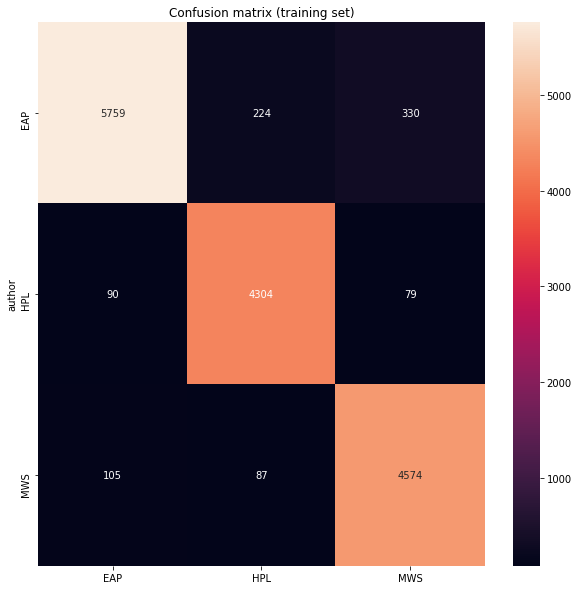

In [33]:
make_heatmap(train, "Confusion matrix (training set)")

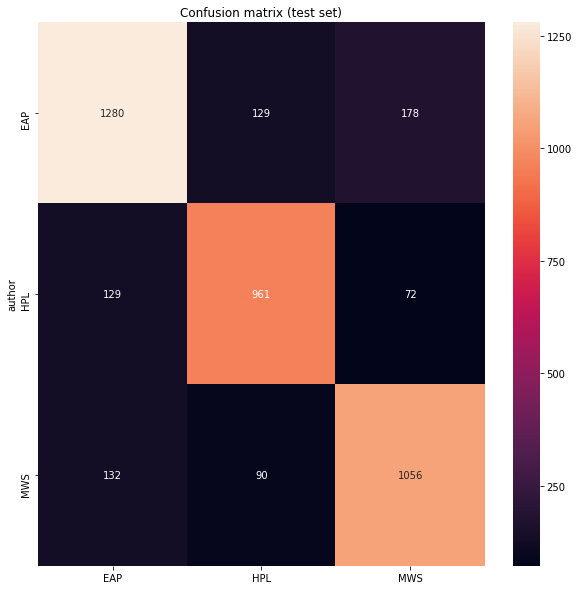

In [34]:
make_heatmap(test, "Confusion matrix (test set)")